In [1]:
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from sklearn. neighbors import KNeighborsClassifier

from ipywidgets import interactive
from collections import defaultdict

import hdbscan
import folium
import re

cols = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
        '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', 
        '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', 
        '#000075', '#808080']*10
sns.set(style="white")

In [2]:
df = pd.read_csv('twitter_posts.csv')
df.head()

Date         Username  longitude   latitude  \
0  2023-03-18 16:28:04+00:00          RokebyM  67.997691   6.622513   
1  2023-03-18 11:20:07+00:00          watwijm  94.944302  26.649359   
2  2023-03-18 11:05:10+00:00  travelwitharyan  72.206516  27.698326   
3  2023-03-18 11:03:32+00:00  travelwitharyan  72.206516  27.698326   
4  2023-03-18 08:44:42+00:00  NSivapriyan2141  77.312066   8.230492   

                city country  
0             India'   India  
1  Arunachal Pradesh   India  
2            Bikaner   India  
3            Bikaner   India  
4    Padmanabhapuram   India

### Dropping NaN and Duplicates

In [3]:
print(f'Before dropping values\t:\tdf.shape = {df.shape}')
df.dropna(inplace=True)
df.drop_duplicates(subset = ['latitude','longitude'], keep='first', inplace=True)
print(f'After dropping values\t:\tdf.shape = {df.shape}')

Before dropping values	:	df.shape = (1803, 6)
After dropping values	:	df.shape = (604, 6)


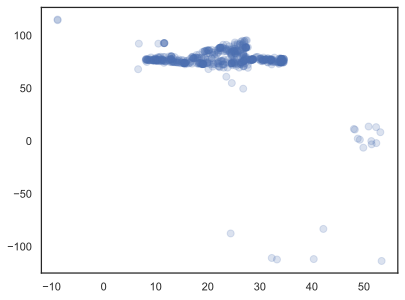

In [4]:
X = np.array(df[['latitude', 'longitude']], dtype='float64')
plt.scatter(X[:,0], X[:,1], alpha=0.2, s=50)

In [5]:
m = folium.Map(location=[df.latitude.mean(), df.longitude.mean()], zoom_start=9, tiles='OpenStreet Map')

for _, row in df.iterrows():
    folium.CircleMarker(location=[row.latitude, row.longitude], radius = 5, popup=row['city'], color = '#1787FE',fill=True, fill_colour='#1787FE').add_to(m)
    
m

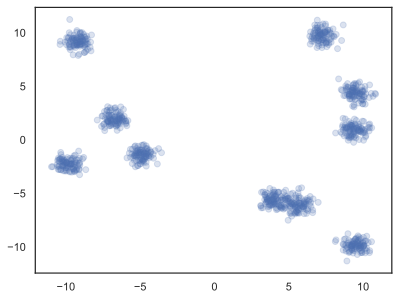

In [6]:
X_blobs,_ = make_blobs(n_samples=1000,centers=10, n_features=2, cluster_std=0.5, random_state=4)
plt.scatter(X_blobs[:,0], X_blobs[:,1], alpha = 0.2)

In [7]:
class_predictions = np.load('sample_clusters.npy')

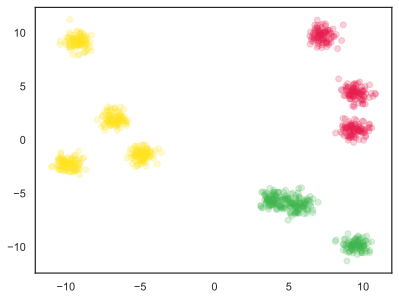

In [8]:
unique_clusters = np.unique(class_predictions)
for unique_cluster in unique_clusters:
    X = X_blobs[class_predictions==unique_cluster]
    plt.scatter(X[:,0],X[:,1], alpha=0.2, c=cols[unique_cluster])

In [9]:
silhouette_score(X_blobs,class_predictions)

0.6657220862867241

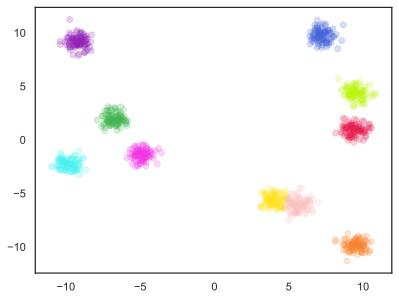

In [10]:
class_predictions = np.load('sample_clusters_improved.npy')
unique_clusters = np.unique(class_predictions)
for unique_cluster in unique_clusters:
    X = X_blobs[class_predictions==unique_cluster]
    plt.scatter(X[:,0], X[:,1], alpha=0.2, c=cols[unique_cluster])

In [11]:
silhouette_score(X_blobs,class_predictions)

0.7473587799908298

## K-Means Clustering

In [12]:
X_blobs,_ = make_blobs(n_samples=1000, centers=50, n_features=2, cluster_std=1,random_state=4)

In [13]:
data= defaultdict(dict)

for x in range(1,21):
    model = KMeans(n_clusters=3, random_state=17, max_iter=x, n_init=1).fit(X_blobs)
    
    data[x]['class_predictions'] = model.predict(X_blobs)
    data[x]['centroids'] = model.cluster_centers_
    data[x]['unique_classes'] = np.unique(class_predictions)

In [14]:
def f(x):
    
    class_predictions = data[x]['class_predictions']
    centroids = data[x]['centroids']
    unique_classes = data[x]['unique_classes']
    
    for unique_class in unique_classes:
        plt.scatter(X_blobs[class_predictions == unique_class][:,0],
                   X_blobs[class_predictions==unique_class][:,1],
                   alpha=0.3, c=cols[unique_class])
        
    plt.scatter(centroids[:,0], centroids[:,1], s=200, c='#000000', marker='v')
    plt.ylim([-15,15]); plt.xlim([-15,15])
    plt.title('How K-Means Clusters')
    

interactive_plot = interactive(f,x=(1,10))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=5, description='x', max=10, min=1), Output(layout=Layout(height='350px')…

In [15]:
X = np.array(df[['longitude', 'latitude']], dtype='float64')
k = 70
model = KMeans(n_clusters=k, random_state=17).fit(X)
class_predictions = model.predict(X)
df[f'CLUSTER_kmeans{k}'] = class_predictions

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [16]:
df.head()

Date         Username  longitude   latitude  \
0  2023-03-18 16:28:04+00:00          RokebyM  67.997691   6.622513   
1  2023-03-18 11:20:07+00:00          watwijm  94.944302  26.649359   
2  2023-03-18 11:05:10+00:00  travelwitharyan  72.206516  27.698326   
4  2023-03-18 08:44:42+00:00  NSivapriyan2141  77.312066   8.230492   
5  2023-03-17 14:38:59+00:00    tourism_udupi  74.667323  13.086056   

                city country  CLUSTER_kmeans70  
0             India'   India                33  
1  Arunachal Pradesh   India                16  
2            Bikaner   India                63  
4    Padmanabhapuram   India                 8  
5              Udupi   India                23

In [17]:
def create_map(df, cluster_column):
    m = folium.Map(location=[df.latitude.mean(), df.longitude.mean()], zoom_start=9, titles='OpenStreet Map')
    
    for _, row in df.iterrows():
        if row[cluster_column] == -1:
            cluster_color = '#000000'
        else:
            cluster_color = cols[row[cluster_column]]
        
        folium.CircleMarker(location=[row['latitude'], row['longitude']],
                           radius=5,
                           popup= row[cluster_column],
                           color=cluster_color,
                           fill=True,
                           fill_color = cluster_color).add_to(m)
    return m

m = create_map(df,'CLUSTER_kmeans70')

print(f'K={k}')
print(f'Silhouette Score: {silhouette_score(X,class_predictions)}')


K=70
Silhouette Score: 0.5020110718161712


In [18]:
m

In [19]:
best_silhouette, best_k = -1,0

for k in tqdm(range(2,100)):
    
    model = KMeans(n_clusters=k, random_state=1).fit(X)
    class_predictions = model.predict(X)
    
    curr_silhouette = silhouette_score(X,class_predictions)
    if curr_silhouette > best_silhouette:
        best_k = k
        best_silhouette = curr_silhouette

print(f'K={best_k}')
print(f'Silhouette Score: {best_silhouette}')


  0%|                                                    | 0/98 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  2%|▉                                           | 2/98 [00:00<00:05, 17.36it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/P

 26%|██████████▉                                | 25/98 [00:03<00:15,  4.84it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 27%|███████████▍                               | 26/98 [00:03<00:15,  4.63it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 28%|███████████▊                               | 27/98 [00:03<00:14,  4.94it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n

 49%|█████████████████████                      | 48/98 [00:08<00:12,  3.85it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 50%|█████████████████████▌                     | 49/98 [00:09<00:13,  3.65it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 51%|█████████████████████▉                     | 50/98 [00:09<00:13,  3.64it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n

 72%|███████████████████████████████▏           | 71/98 [00:16<00:09,  2.85it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 73%|███████████████████████████████▌           | 72/98 [00:16<00:09,  2.73it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 74%|████████████████████████████████           | 73/98 [00:16<00:09,  2.72it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n

 96%|█████████████████████████████████████████▏ | 94/98 [00:25<00:01,  2.49it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 97%|█████████████████████████████████████████▋ | 95/98 [00:25<00:01,  2.47it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 98%|██████████████████████████████████████████ | 96/98 [00:25<00:00,  2.45it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n

K=2
Silhouette Score: 0.8828104815384913


### DBSCAN

In [20]:
dummy = np.array([-1, -1, -1, 2, 3, 4, 5,-1])
new = np.array([(counter+2)*x if x == -1 else x for counter, x in enumerate(dummy)])

In [21]:
model = DBSCAN(eps=0.01, min_samples=5).fit(X)
class_predictions = model.labels_
df['CLUSTERS_DBSCAN'] = class_predictions

In [22]:
m = create_map(df, 'CLUSTERS_DBSCAN')

print(f'Number of Clusters found: {len(np.unique(class_predictions))}')
print(f'Number of Outliers found: {len(class_predictions[class_predictions==-1])}')

print(f'Silhouette Ignoring outliers: {silhouette_score(X[class_predictions!=-1], class_predictions[class_predictions!=-1])}')

no_outliers = 0
no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(class_predictions)])
print(f'Silhouette outliers as singletons: {silhouette_score(X, no_outliers)}')

Number of Clusters found: 3
Number of Outliers found: 588
Silhouette Ignoring outliers: 0.9994074658745187
Silhouette outliers as singletons: 0.01794606228669233


In [23]:
m

### HDBSCAN

In [24]:
model = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=2, cluster_selection_epsilon=0.01)

class_predictions = model.fit_predict(X)
df['CLUSTER_HDBSCAN'] = class_predictions

In [25]:
df.head()

Date         Username  longitude   latitude  \
0  2023-03-18 16:28:04+00:00          RokebyM  67.997691   6.622513   
1  2023-03-18 11:20:07+00:00          watwijm  94.944302  26.649359   
2  2023-03-18 11:05:10+00:00  travelwitharyan  72.206516  27.698326   
4  2023-03-18 08:44:42+00:00  NSivapriyan2141  77.312066   8.230492   
5  2023-03-17 14:38:59+00:00    tourism_udupi  74.667323  13.086056   

                city country  CLUSTER_kmeans70  CLUSTERS_DBSCAN  \
0             India'   India                33               -1   
1  Arunachal Pradesh   India                16               -1   
2            Bikaner   India                63               -1   
4    Padmanabhapuram   India                 8               -1   
5              Udupi   India                23               -1   

   CLUSTER_HDBSCAN  
0               -1  
1                5  
2               -1  
4               37  
5               35

In [26]:
m = create_map(df, 'CLUSTER_HDBSCAN')
print(f'Number of clusters found: {len(np.unique(class_predictions))-1}')
print(f'Number of outliers found: {len(class_predictions[class_predictions==-1])}')

print(f'Silhouette ignoring outliers: {silhouette_score(X[class_predictions!=-1], class_predictions[class_predictions!=-1])}')

no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(class_predictions)])
print(f'Silhouette outliers as singletons: {silhouette_score(X, no_outliers)}')

Number of clusters found: 45
Number of outliers found: 179
Silhouette ignoring outliers: 0.6313496724495851
Silhouette outliers as singletons: 0.32057324658134406


In [27]:
m

In [28]:
hdbscan.HDBSCAN?

### Addressing Outliers

In [29]:
classifier = KNeighborsClassifier(n_neighbors=1)

In [30]:
df_train = df[df.CLUSTER_HDBSCAN != 1]
df_predict = df[df.CLUSTER_HDBSCAN==-1]

In [31]:
X_train = np.array(df_train[['longitude', 'latitude']], dtype='float64')
y_train = np.array(df_train['CLUSTER_HDBSCAN'])
X_predict = np.array(df_predict[['longitude', 'latitude']], dtype='float64')

In [32]:
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [33]:
predictions = classifier.predict(X_predict)

In [34]:
df['CLUSTER_hybrid'] = df['CLUSTER_HDBSCAN']

In [35]:
df.loc[df.CLUSTER_HDBSCAN==-1, 'CLUSTER_hybrid'] = predictions

In [36]:
m = create_map(df, 'CLUSTER_hybrid')

In [37]:
m

In [38]:
df.head()

Date         Username  longitude   latitude  \
0  2023-03-18 16:28:04+00:00          RokebyM  67.997691   6.622513   
1  2023-03-18 11:20:07+00:00          watwijm  94.944302  26.649359   
2  2023-03-18 11:05:10+00:00  travelwitharyan  72.206516  27.698326   
4  2023-03-18 08:44:42+00:00  NSivapriyan2141  77.312066   8.230492   
5  2023-03-17 14:38:59+00:00    tourism_udupi  74.667323  13.086056   

                city country  CLUSTER_kmeans70  CLUSTERS_DBSCAN  \
0             India'   India                33               -1   
1  Arunachal Pradesh   India                16               -1   
2            Bikaner   India                63               -1   
4    Padmanabhapuram   India                 8               -1   
5              Udupi   India                23               -1   

   CLUSTER_HDBSCAN  CLUSTER_hybrid  
0               -1              -1  
1                5               5  
2               -1              -1  
4               37              37  
5               35              35

In [39]:
class_predictions = df.CLUSTER_hybrid
print(f'Number of clusters found: {len(np.unique(class_predictions))}')
print(f'Silhouette: {silhouette_score(X, class_predictions)}')

m.save('hybrid.html')

Number of clusters found: 46
Silhouette: 0.1930880444465352


Text(0.5, 0, 'Cluster Sizes')

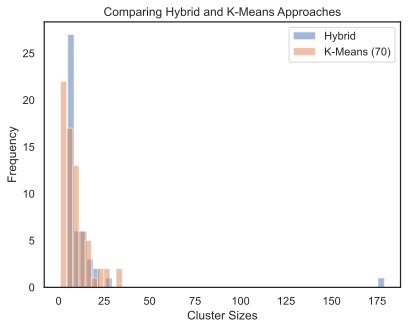

In [40]:
df['CLUSTER_hybrid'].value_counts().plot.hist(bins=50, alpha=0.5, 
                                              label='Hybrid')
df['CLUSTER_kmeans70'].value_counts().plot.hist(bins=10, alpha=0.5,
                                               label='K-Means (70)')
plt.legend()
plt.title('Comparing Hybrid and K-Means Approaches')
plt.xlabel('Cluster Sizes')

In [42]:
nlp_places_df = pd.read_csv('Locations.csv')

In [43]:
print(f'Before dropping values\t:\tnlp_places_df.shape = {nlp_places_df.shape}')
nlp_places_df.dropna(inplace=True)
nlp_places_df.drop_duplicates(subset = ['Place'], keep='first', inplace=True)
print(f'After dropping values\t:\tnlp_places_df.shape = {nlp_places_df.shape}')

Before dropping values	:	nlp_places_df.shape = (16829, 1)
After dropping values	:	nlp_places_df.shape = (2280, 1)


In [46]:
test_df = nlp_places_df

In [71]:
import geopy
from geopy.geocoders import Nominatim
import time

df_new = pd.DataFrame(columns=['longitude', 'latitude', 'City'])

geolocator = Nominatim(user_agent="my-app")
for index, row in nlp_places_df.iterrows():
    city = row['Place']
    while True:
        try:
            location = geolocator.geocode(city, timeout=10)
            if location:
                longitude = location.longitude
                latitude = location.latitude
                df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
        
            break
        except geopy.exc.GeocoderUnavailable:
            print('Geocoder is unavailable. Waiting for 5 seconds before trying again...')
            time.sleep(5)
    
        


/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_8633/3442705908.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
/var/folders/0z/2tqs8bgj7j74q8364l

In [72]:
df_new.head(20)

longitude   latitude City       Place
0    13.780363   8.771279  NaN       North
1    78.667743  22.351115  NaN       India
2    85.438846  23.967515  NaN  Hazaribagh
3    91.299910  25.537943  NaN   Meghalaya
4    78.085349  32.370901  NaN       Spiti
5    77.375725  28.662881  NaN  Vasundhara
6    77.310556  28.403148  NaN   Faridabad
7    79.415481  29.294783  NaN    Nainital
8    77.489465  31.998651  NaN  Kheerganga
9    77.170973  31.104153  NaN      Shimla
10   74.011454  15.562648  NaN    Sankhali
11   72.878176  19.078545  NaN      Mumbai
12   85.123525  25.609324  NaN       Patna
13   85.906508  25.644085  NaN       Bihar
14  103.944985   1.323448  NaN         Eco
15 -105.756164  39.108930  NaN        Park
16   88.363895  22.572646  NaN     Kolkata
17   77.221939  28.651718  NaN       Delhi
18   78.009816  27.175255  NaN        Agra
19   75.818982  26.915458  NaN      Jaipur

In [73]:
df_new.shape

(2059, 4)

In [74]:
np.savetxt("Locations.csv", df_new, delimiter=", ", fmt="%s")

In [77]:
final_dataframe = pd.read_csv('Locations.csv')

In [78]:
final_dataframe.head()

longitude   latitude        Place
0  13.780363   8.771279        North
1  78.667743  22.351115        India
2  85.438846  23.967515   Hazaribagh
3  91.299910  25.537943    Meghalaya
4  78.085349  32.370901        Spiti

In [79]:
final_dataframe['Cluster_HDBSCAN'] = model.fit_predict(final_dataframe[['longitude', 'latitude']])

In [80]:
final_dataframe.head(20)

longitude   latitude        Place  Cluster_HDBSCAN
0    13.780363   8.771279        North               10
1    78.667743  22.351115        India               79
2    85.438846  23.967515   Hazaribagh               85
3    91.299910  25.537943    Meghalaya               55
4    78.085349  32.370901        Spiti              138
5    77.375725  28.662881   Vasundhara              122
6    77.310556  28.403148    Faridabad              122
7    79.415481  29.294783     Nainital              125
8    77.489465  31.998651   Kheerganga              157
9    77.170973  31.104153       Shimla              149
10   74.011454  15.562648     Sankhali               -1
11   72.878176  19.078545       Mumbai              108
12   85.123525  25.609324        Patna               92
13   85.906508  25.644085        Bihar               92
14  103.944985   1.323448          Eco               13
15 -105.756164  39.108930         Park               16
16   88.363895  22.572646      Kolkata               77
17   77.221939  28.651718        Delhi              122
18   78.009816  27.175255         Agra              143
19   75.818982  26.915458       Jaipur              141